In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw

In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.96.0


In [3]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
from pathlib import Path

import warnings
warnings.simplefilter("ignore")

%matplotlib widget

In [33]:
base_folder = Path("D:\KILOSORT-DATA\Day81 Ens71 (dlPFC HPC)")
header_file = list(base_folder.glob("*.json"))[0]
data_path = list(base_folder.glob("*data.xdat"))[0]

"""
0 = A Probe
1 = B Probe
"""
probe_ = 1;

with open(header_file) as file_:
    header_data = json.load(file_)

samp_freq = header_data['status']['samp_freq']
nchannels = header_data['status']['signals']['total']
pri_chans = header_data['status']['signals']['pri']

chan_names = header_data['sapiens_base']['biointerface_map']['chan_name']
sync_channel = chan_names.index('din_1')

ports = header_data['sapiens_base']['biointerface_map']['port'][:pri_chans]
port_name, channel_offset, channel_per_probe = np.unique(ports,return_index=True,return_counts=True)

ypos_all = header_data['sapiens_base']['biointerface_map']['site_ctr_tcs_y'][:pri_chans]
ypos_per_probe = np.split(np.array(ypos_all),channel_offset[1:])  # probe_channel_index[0] is 0, exclude for splitting

xpos_all = header_data['sapiens_base']['biointerface_map']['site_ctr_tcs_x'][:pri_chans]
xpos_per_probe = np.split(np.array(xpos_all),channel_offset[1:])  # probe_channel_index[0] is 0, exclude for splitting

probe_info = np.column_stack((xpos_all,ypos_all))

chan_ids = header_data['sapiens_base']['biointerface_map']['site_num'][:pri_chans]
for index in range(pri_chans):
    chan_ids[index] -= 1
    chan_ids[index] += channel_offset[probe_]

chan_range = np.arange(channel_offset[probe_],channel_offset[probe_]+channel_per_probe[probe_],1)

channel_gain = 5.0
sorting_alg = 'kilosort2'

In [34]:
recording_binary = si.read_binary(file_paths=data_path,sampling_frequency=samp_freq,dtype='float32',num_chan=nchannels)

In [35]:
recording_binary

BinaryRecordingExtractor: 134 channels - 1 segments - 30.0kHz - 6693.235s
  file_paths: ['D:\\KILOSORT-DATA\\Day81 Ens71 (dlPFC HPC)\\allego_0__uid0307-10-48-15_data.xdat']

In [36]:
recording_binary.annotate(is_filtered=False)

In [37]:
channel_ids = recording_binary.get_channel_ids()
fs = recording_binary.get_sampling_frequency()
num_chan = recording_binary.get_num_channels()
num_segments = recording_binary.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133]
Sampling frequency: 30000
Number of channels: 134
Number of segments: 1


In [38]:
recording_to_process = recording_binary.channel_slice(channel_ids=chan_range)
recording_scaled = spre.scale(recording_to_process, gain=channel_gain);
recording_f = spre.bandpass_filter(recording_scaled, freq_min=300, freq_max=6000)
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')

In [39]:
fs = recording_cmr.get_sampling_frequency()
#recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=1500*fs)
recording_sub = recording_cmr
recording_sub

CommonReferenceRecording: 64 channels - 1 segments - 30.0kHz - 6693.235s

In [40]:
job_kwargs = dict(n_jobs=10, chunk_duration="1s", progress_bar=True)

In [41]:
if probe_ == 0:
    preprocessed_dir = base_folder / "probe_a" / "preprocessed"
else:
    preprocessed_dir = base_folder / "probe_b" / "preprocessed"

if preprocessed_dir.is_dir():
    recording_saved = si.load_extractor(preprocessed_dir)
else:
    recording_saved = recording_sub.save(folder=preprocessed_dir, **job_kwargs)

write_binary_recording with n_jobs = 10 and chunk_size = 30000


write_binary_recording:   0%|          | 0/6694 [00:00<?, ?it/s]

In [42]:
traces_f = recording_f.get_traces(start_frame=0, end_frame=int(5*fs))
traces_raw = recording_scaled.get_traces(start_frame=0, end_frame=int(5*fs))

In [21]:
from matplotlib import gridspec


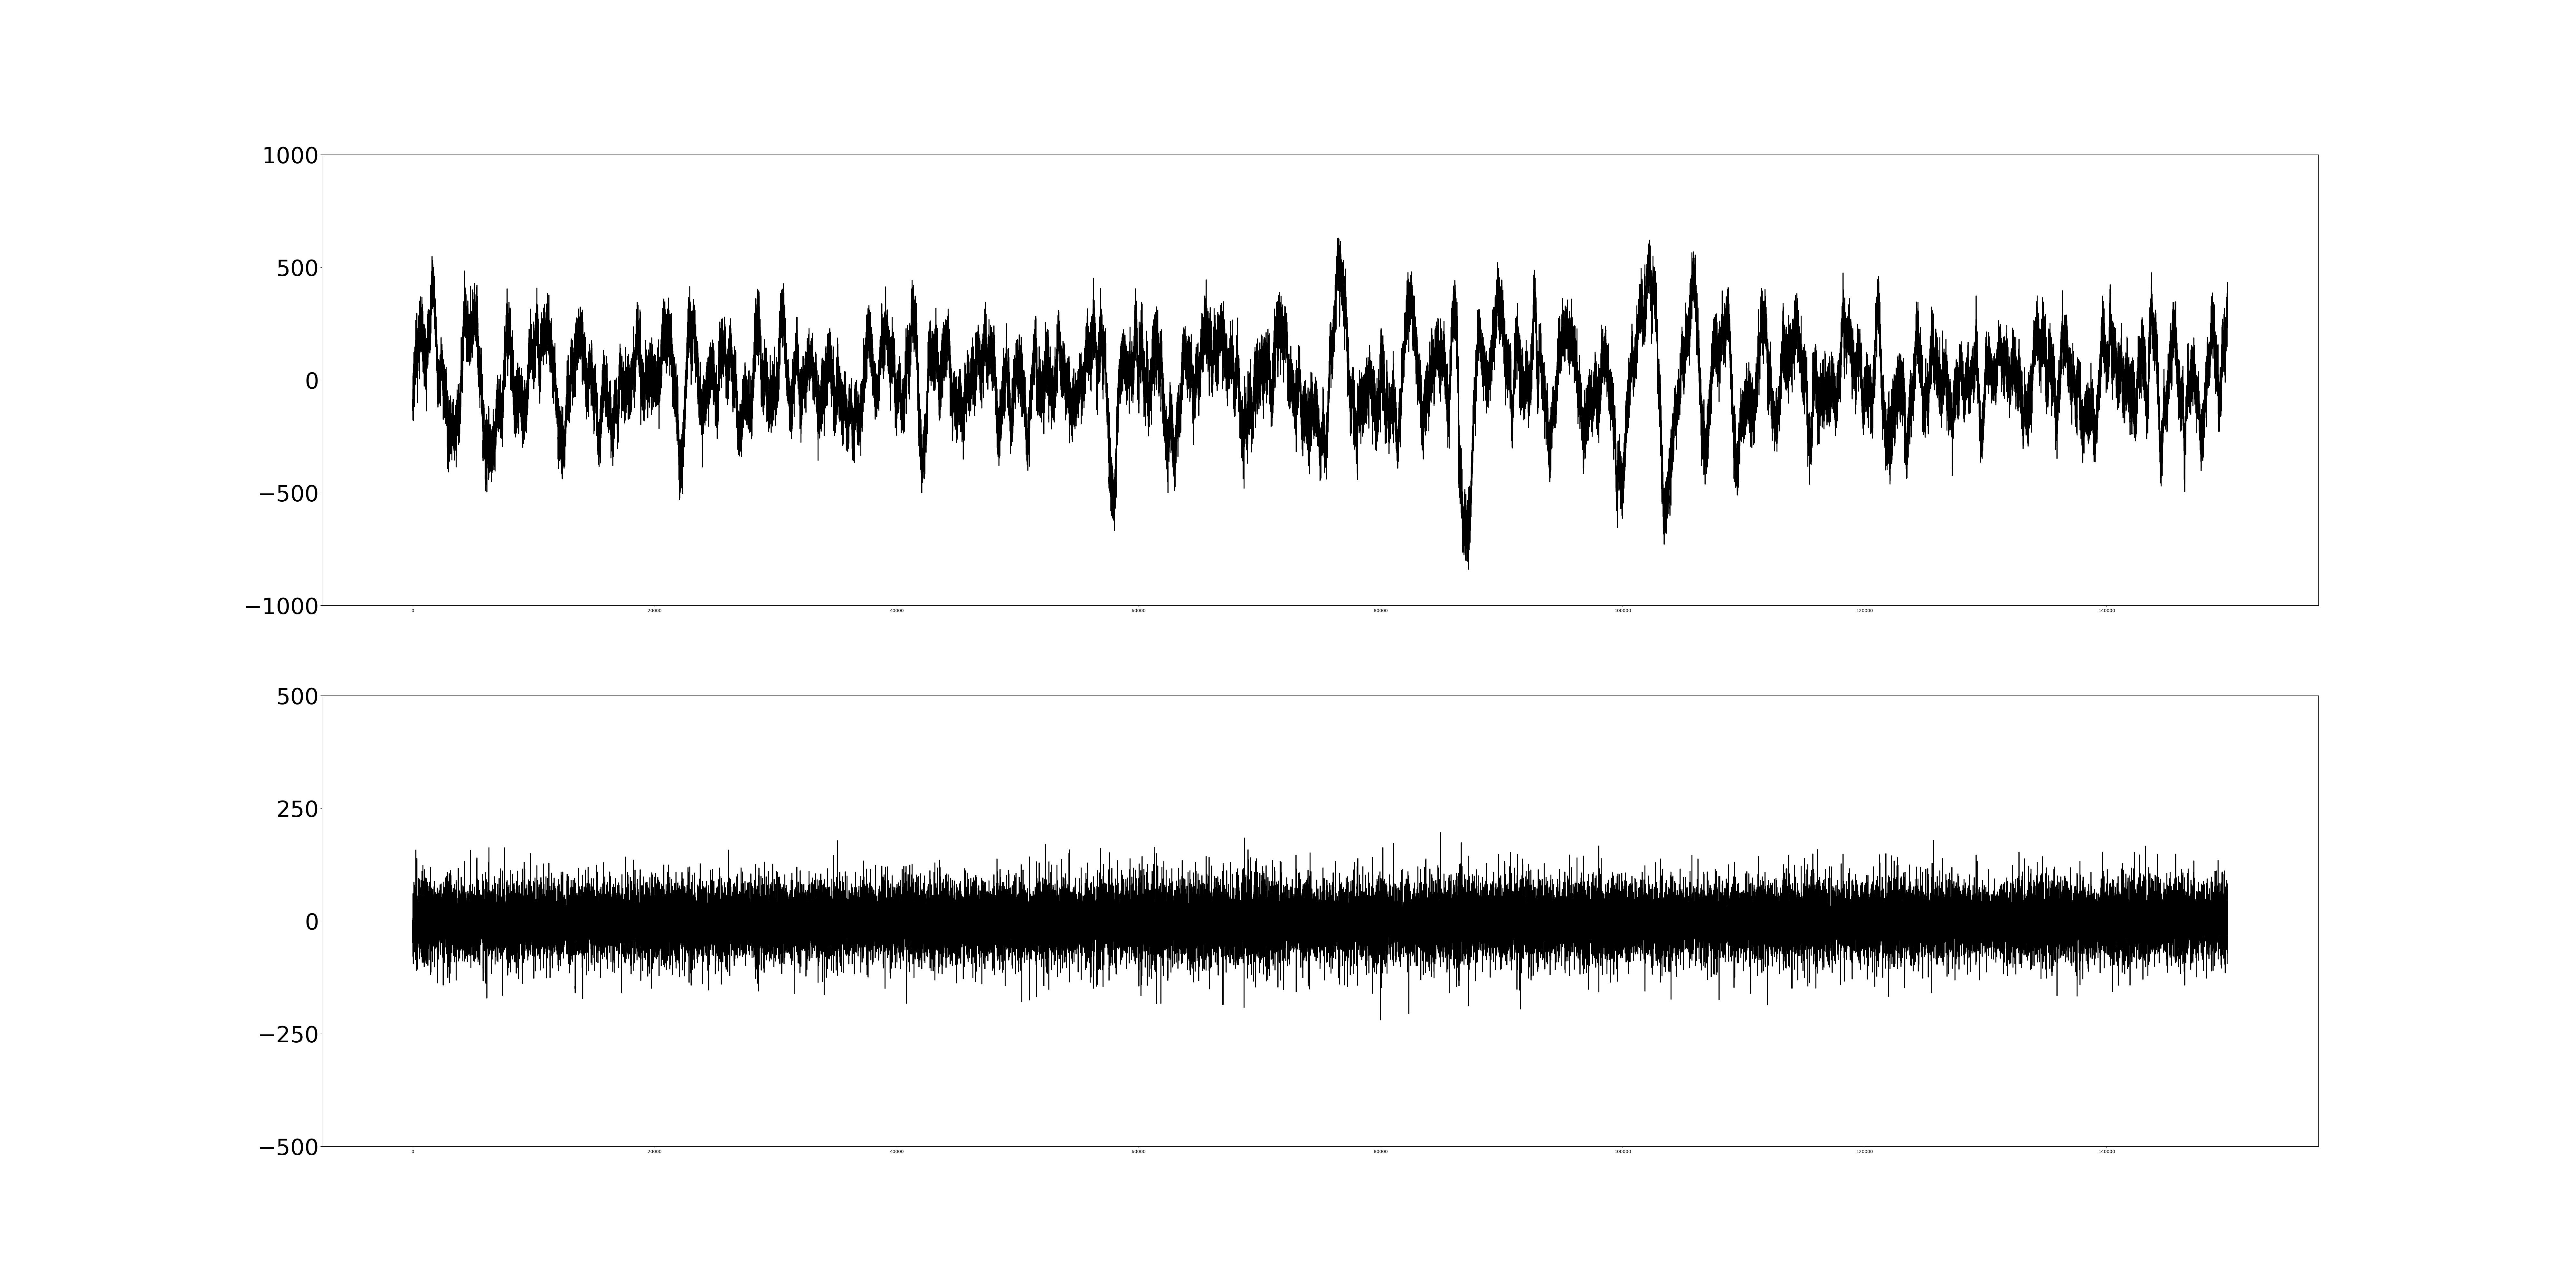

In [54]:
for ch in range(64):

    plt.close('all')
    plt.figure(figsize=(80,40))
    gs = gridspec.GridSpec(2, 1) 

    ax = plt.subplot(gs[0])
    plt.plot(traces_raw[:,ch],'k-',lw=2)
    plt.yticks(np.linspace(-1000,1000,5),fontsize=50)

    ax = plt.subplot(gs[1])
    plt.plot(traces_f[:,ch],'k-',lw=2)
    plt.yticks(np.linspace(-500,500,5),fontsize=50)

#     ax = plt.subplot(gs[2])
#     plt.plot(traces_cmr[:,ch])

    plt.savefig('MYP HPC ch' + str(ch+1) + 'lfp.png')

In [43]:
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [44]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptaamk8iqh\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscripthh30dctc\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptauro06xu\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript4mbgjhox\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptf1bp9eof\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptlzlm_nt6\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptb_zs8ph0\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript7wrjw15y\script.bat


['kilosort2', 'kilosort2_5', 'kilosort3', 'spykingcircus2', 'tridesclous2']

In [45]:
ss.Kilosort3Sorter.set_kilosort3_path('D:\Kilosort-main\Kilosort-main')
ss.Kilosort2_5Sorter.set_kilosort2_5_path('D:\Kilosort-2.5')
ss.Kilosort2Sorter.set_kilosort2_path('D:\Kilosort-2.0\Kilosort-2.0')

Setting KILOSORT3_PATH environment variable for subprocess calls to: D:\Kilosort-main\Kilosort-main
Setting KILOSORT2_5_PATH environment variable for subprocess calls to: D:\Kilosort-2.5
Setting KILOSORT2_PATH environment variable for subprocess calls to: D:\Kilosort-2.0\Kilosort-2.0


In [46]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscripty67xl7mz\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptqxgifd7k\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscripthfdnrtvi\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript8l_s2_en\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptl_66vphz\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptg32zhiwb\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript_fjszvu9\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptas64fk6s\script.bat


['kilosort2', 'kilosort2_5', 'kilosort3', 'spykingcircus2', 'tridesclous2']

In [47]:
ss.get_sorter_params_description(sorting_alg)

{'detect_threshold': 'Threshold for spike detection',
 'projection_threshold': 'Threshold on projections',
 'preclust_threshold': 'Threshold crossings for pre-clustering (in PCA projection space)',
 'car': 'Enable or disable common reference',
 'minFR': 'Minimum spike rate (Hz), if a cluster falls below this for too long it gets removed',
 'minfr_goodchannels': "Minimum firing rate on a 'good' channel",
 'freq_min': 'High-pass filter cutoff frequency',
 'sigmaMask': 'Spatial constant in um for computing residual variance of spike',
 'nPCs': 'Number of PCA dimensions',
 'ntbuff': 'Samples of symmetrical buffer for whitening and spike detection',
 'nfilt_factor': 'Max number of clusters per good channel (even temporary ones) 4',
 'NT': 'Batch size (if None it is automatically computed)',
 'wave_length': 'size of the waveform extracted around each detected peak, (Default 61, maximum 81)',
 'keep_good_only': "If True only 'good' units are returned",
 'n_jobs': 'Number of jobs (when saving 

In [48]:
ss.get_default_sorter_params(sorting_alg)

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'wave_length': 61,
 'keep_good_only': False,
 'n_jobs': 1,
 'total_memory': None,
 'chunk_size': None,
 'chunk_memory': None,
 'chunk_duration': '1s',
 'progress_bar': True}

In [49]:
ss.run_sorter?

In [20]:
sorter_params = {'do_correction': False}

In [50]:
recording_saved.set_channel_locations(probe_info[chan_range], channel_ids=chan_ids[channel_offset[probe_]:(channel_offset[probe_]+channel_per_probe[probe_])])

In [51]:
# run spike sorting on entire recording
if probe_ == 0:
    output_folder = base_folder / 'probe_a' / sorting_alg
else:
    output_folder = base_folder / 'probe_b' / sorting_alg
    
# sorting_KS3 = ss.run_sorter(sorting_alg, recording_saved,
#                              output_folder=output_folder,
#                              verbose=True, **sorter_params, **job_kwargs)

sorting_output = ss.run_sorter(sorting_alg, recording_saved,
                             output_folder=output_folder,
                             verbose=True,  **job_kwargs)

RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript_3trn8rl\script.bat


write_binary_recording:   0%|          | 0/6694 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptvv4lmd47\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript99mp7ie9\script.bat
RUNNING SHELL SCRIPT: D:\KILOSORT-DATA\Day81 Ens71 (dlPFC HPC)\probe_b\kilosort2\run_kilosort2.bat


C:\Users\leelab\Documents\GitHub\MazeTaskAnalysis>D:



D:\>cd D:\KILOSORT-DATA\Day81 Ens71 (dlPFC HPC)\probe_b\kilosort2 



D:\KILOSORT-DATA\Day81 Ens71 (dlPFC HPC)\probe_b\kilosort2>matlab -nosplash -wait -r "kilosort2_master('D:\KILOSORT-DATA\Day81 Ens71 (dlPFC HPC)\probe_b\kilosort2', 'D:\Kilosort-2.0\Kilosort-2.0')" 

kilosort2 run time 793.86s


In [53]:
if sorting_alg == 'kilosort2':
    # Update params.py to point to temp_wh.dat locally
    params_file = output_folder / 'params.py'
    
    with open(params_file,'r') as file_:
        params_ = file_.readlines()
    
    if params_:
        params_[0] = 'dat_path = \'temp_wh.dat\'\n'
        with open(params_file,'w') as file_:
            file_.writelines(params_)

    # Delete the unnecessary recording.dat if it exists
    tbd = output_folder / 'recording.dat'
    if os.path.exists(tbd):
        os.remove(tbd)

    # Extract phy waveforms
    phy_script = r'D:\SpikeInterface\run_phy.bat'
    subprocess.run([phy_script, output_folder])

    # Extract timing signal if not done already
    if not os.path.exists(base_folder / 'timestamps.data'):
        subprocess.run(['python','D:/SpikeInterface/extract_timing.py',data_path,str(samp_freq),str(nchannels),str(sync_channel),"4"])